In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.models import resnet18
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
import tqdm
from tqdm.auto import tqdm as tqdm_auto
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms import ToTensor, ToPILImage
import matplotlib.pyplot as plt
from PIL import Image
    

c:\Users\Rishita\Desktop\MMDP-Research-Paper\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Understanding visualizations

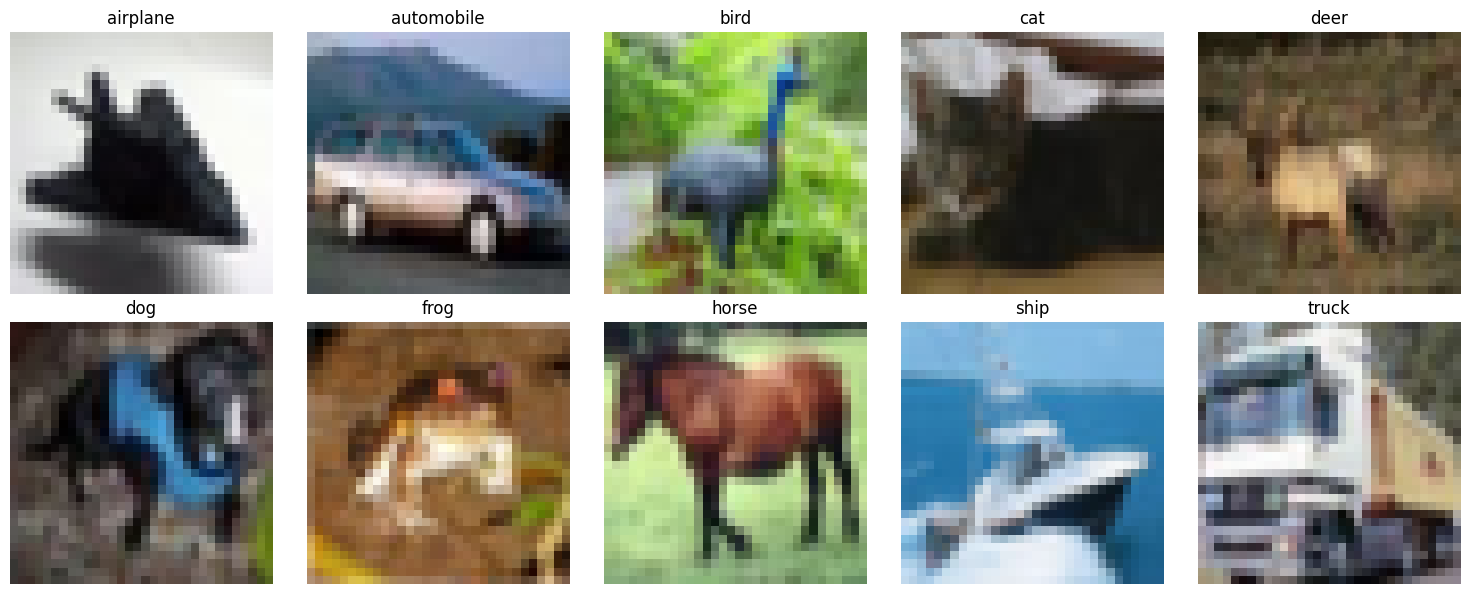

In [2]:
# Load CIFAR-10 dataset
dataset = CIFAR10(root='./data', train=True, transform=ToTensor(), download=True)

# CIFAR-10 class names
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck']

# Create a figure with 10 subplots (one for each class)
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

# Keep track of classes we've seen
seen_classes = set()

# Go through the dataset until we find one example of each class
for data_idx in range(len(dataset)):
    img, label = dataset[data_idx]
    class_name = classes[label]
    
    # If we haven't seen this class yet, display the image
    if label not in seen_classes:
        # Get the appropriate subplot
        ax = axes[label]
        
        # Convert tensor to numpy for displaying
        img = img.permute(1, 2, 0).numpy()  # Change CxHxW to HxWxC
        
        # Display the image
        ax.imshow(img)
        ax.set_title(class_name)
        ax.axis('off')
        
        # Add this class to our seen set
        seen_classes.add(label)
    
    # If we've seen all classes, break the loop
    if len(seen_classes) == 10:
        break

plt.tight_layout()
plt.show()

## Data Augmentations

#### Random cropping

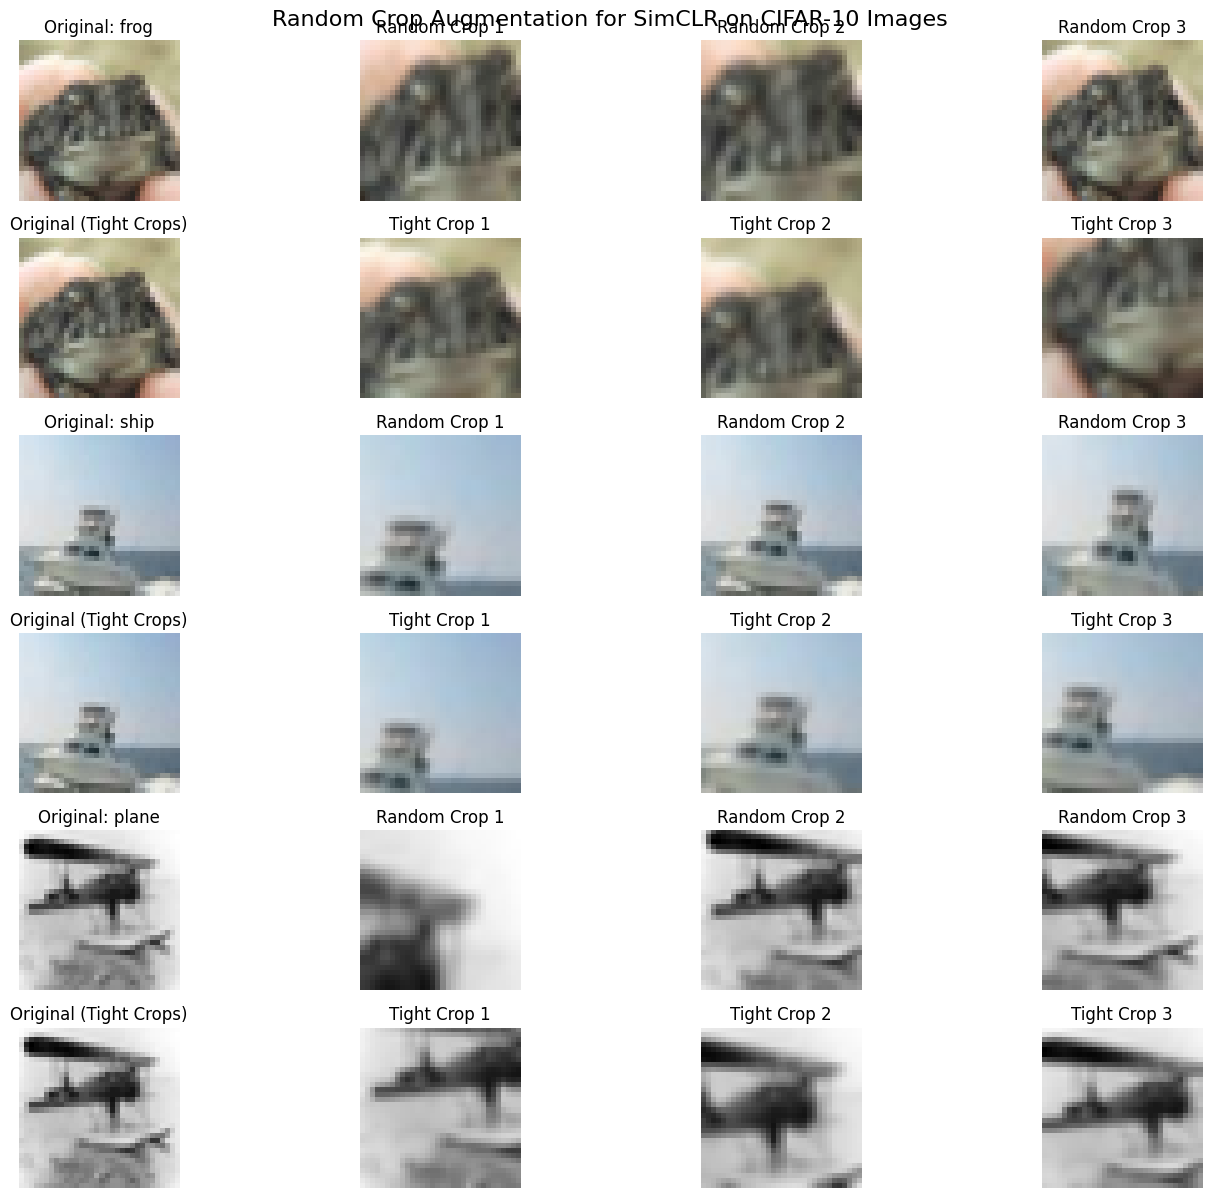

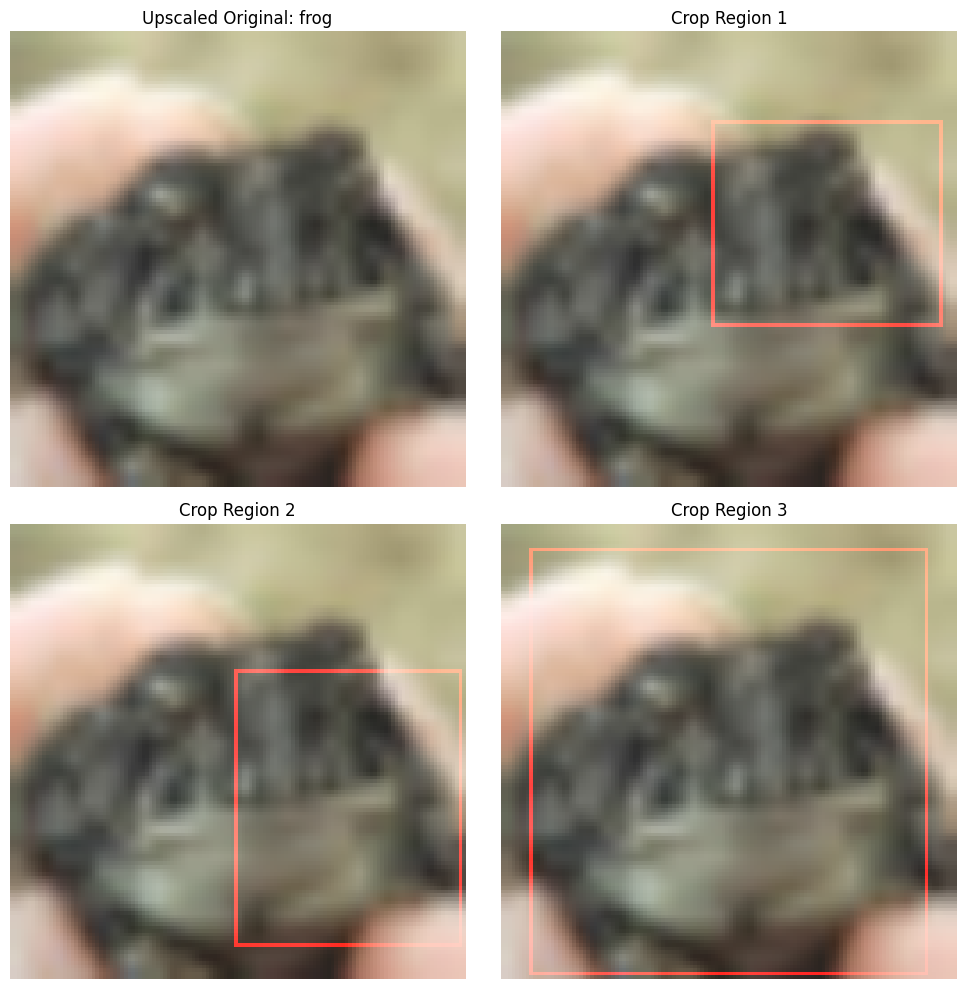

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Load CIFAR-10 dataset
transform = transforms.ToTensor()  # Just convert to tensor, no normalization for visualization
cifar_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Choose several images for demonstration
image_indices = [25, 100, 2021]  # Pick diverse images
images = []
labels = []
for idx in image_indices:
    img, label = cifar_dataset[idx]
    images.append(img)
    labels.append(label)

# Define the random crop transformation
random_crop = transforms.RandomResizedCrop(
    size=32,  # CIFAR-10 images are 32x32
    scale=(0.08, 1.0),  # Range of size of the origin crop (as in SimCLR)
    ratio=(0.75, 1.33),  # Range of aspect ratio of the origin crop
    interpolation=transforms.InterpolationMode.BICUBIC
)

# Function to convert tensor to displayable image
def tensor_to_img(tensor):
    img = tensor.permute(1, 2, 0).numpy()  # Change from (C,H,W) to (H,W,C)
    # Clip values to [0, 1] range in case of any overflow
    img = np.clip(img, 0, 1)
    return img

# Get the class names
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
class_names = [classes[label] for label in labels]

# Create a figure to display the originals and random crops
plt.figure(figsize=(15, 12))

for img_idx, (img, class_name) in enumerate(zip(images, class_names)):
    row = img_idx * 2

    # Show original image
    plt.subplot(len(images)*2, 4, row*4 + 1)
    plt.imshow(tensor_to_img(img))
    plt.title(f'Original: {class_name}')
    plt.axis('off')
    
    # Create multiple random crops of the same image
    num_crops = 3
    for i in range(num_crops):
        # Apply random crop
        cropped_img = random_crop(img)
        
        # Show random cropped version
        plt.subplot(len(images)*2, 4, row*4 + i + 2)
        plt.imshow(tensor_to_img(cropped_img))
        plt.title(f'Random Crop {i+1}')
        plt.axis('off')
    
    # Show the effects of random crops with tighter constraints
    tight_random_crop = transforms.RandomResizedCrop(
        size=32,
        scale=(0.4, 0.6),  # More zoomed in
        ratio=(0.9, 1.1),  # More square
    )
    
    # Show original image again in second row
    plt.subplot(len(images)*2, 4, (row+1)*4 + 1)
    plt.imshow(tensor_to_img(img))
    plt.title(f'Original (Tight Crops)')
    plt.axis('off')
    
    # Show tight random crops
    for i in range(num_crops):
        # Apply tight random crop
        tight_cropped_img = tight_random_crop(img)
        
        # Show random cropped version
        plt.subplot(len(images)*2, 4, (row+1)*4 + i + 2)
        plt.imshow(tensor_to_img(tight_cropped_img))
        plt.title(f'Tight Crop {i+1}')
        plt.axis('off')

plt.tight_layout()
plt.suptitle('Random Crop Augmentation for SimCLR on CIFAR-10 Images', fontsize=16, y=0.995)
plt.savefig('cifar10_random_crops.png')
plt.show()

# Visualize the random crop regions on a larger image for better understanding
plt.figure(figsize=(10, 10))

# Create a larger image by upscaling a CIFAR-10 image
img_large = transforms.Resize(128)(images[0])

# Show the original larger image
plt.subplot(2, 2, 1)
plt.imshow(tensor_to_img(img_large))
plt.title(f'Upscaled Original: {class_names[0]}')
plt.axis('off')

# Create 3 random crop boxes to visualize
crop_boxes = []
for i in range(3):
    # Get random crop parameters (top, left, height, width)
    i, j, h, w = random_crop.get_params(img_large, scale=(0.08, 1.0), ratio=(0.75, 1.33))
    crop_boxes.append((i, j, h, w))

# Plot each random crop region on the original image
for idx, (i, j, h, w) in enumerate(crop_boxes):
    plt.subplot(2, 2, idx + 2)
    
    # Create a copy of the image to draw the crop box on
    img_with_box = tensor_to_img(img_large).copy()
    
    # Draw a red rectangle showing the crop region
    img_with_box[i:i+1, j:j+w, 0] = 1.0  # Top edge (red)
    img_with_box[i+h-1:i+h, j:j+w, 0] = 1.0  # Bottom edge (red)
    img_with_box[i:i+h, j:j+1, 0] = 1.0  # Left edge (red)
    img_with_box[i:i+h, j+w-1:j+w, 0] = 1.0  # Right edge (red)
    
    plt.imshow(img_with_box)
    plt.title(f'Crop Region {idx+1}')
    plt.axis('off')

plt.tight_layout()
plt.savefig('random_crop_regions.png')
plt.show()

#### Color distortion

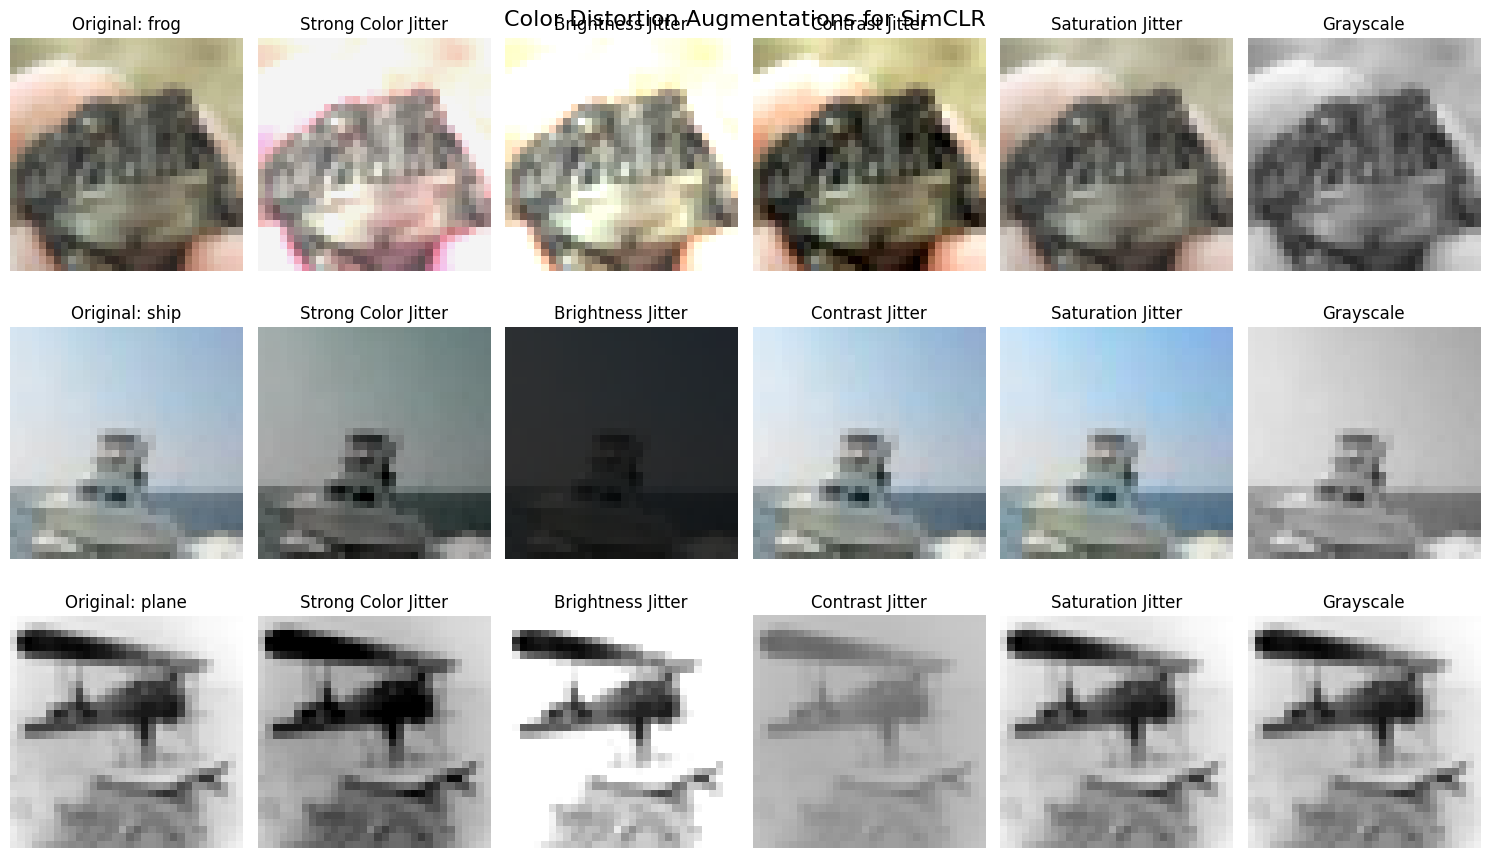

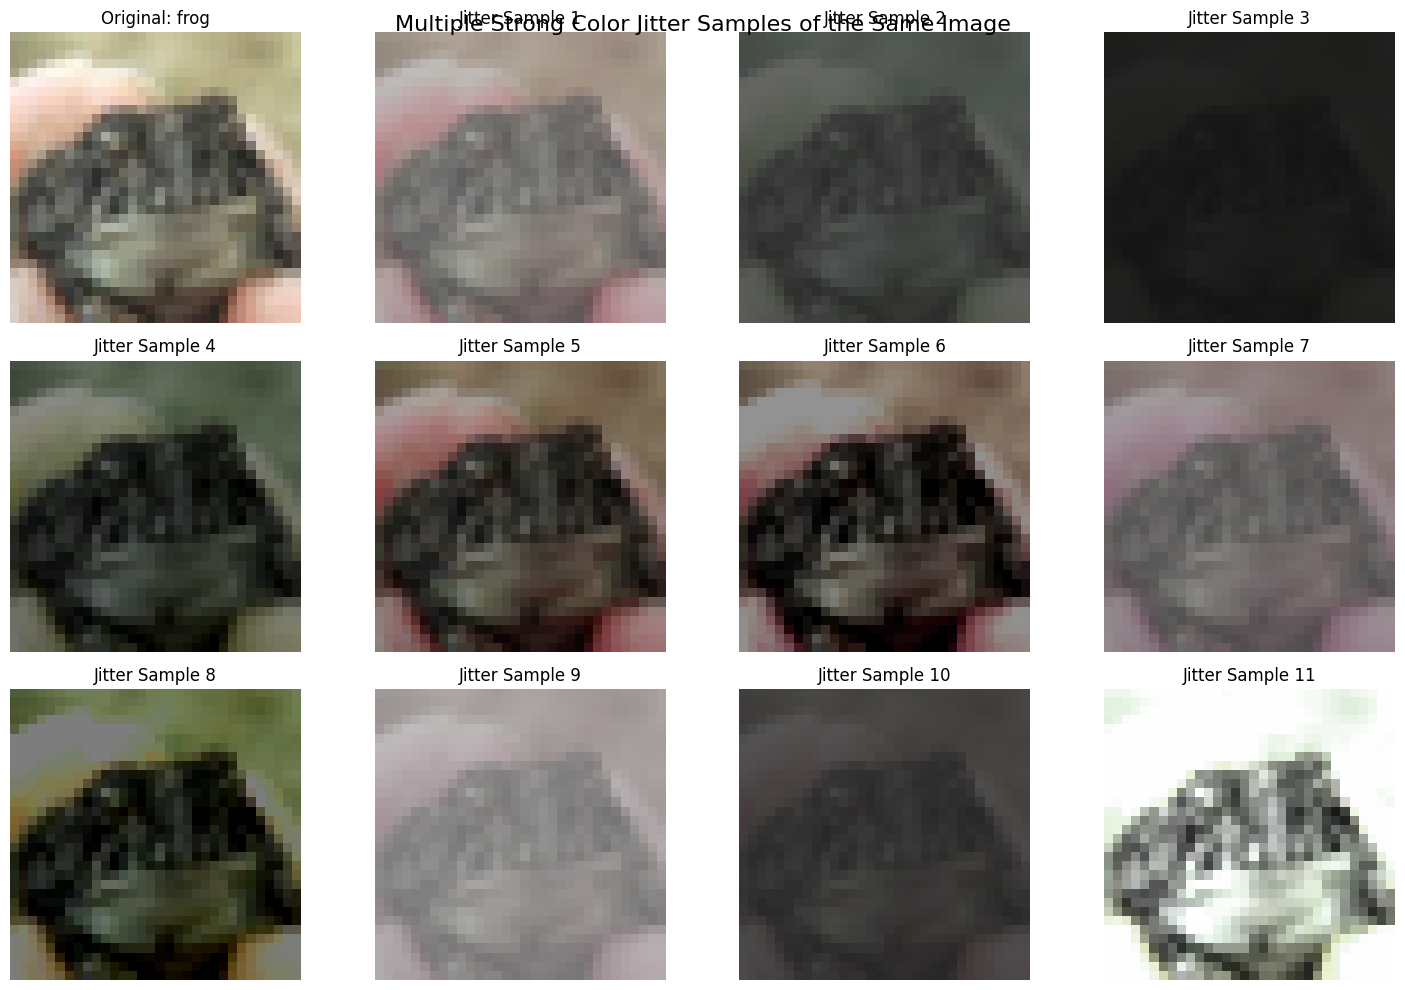

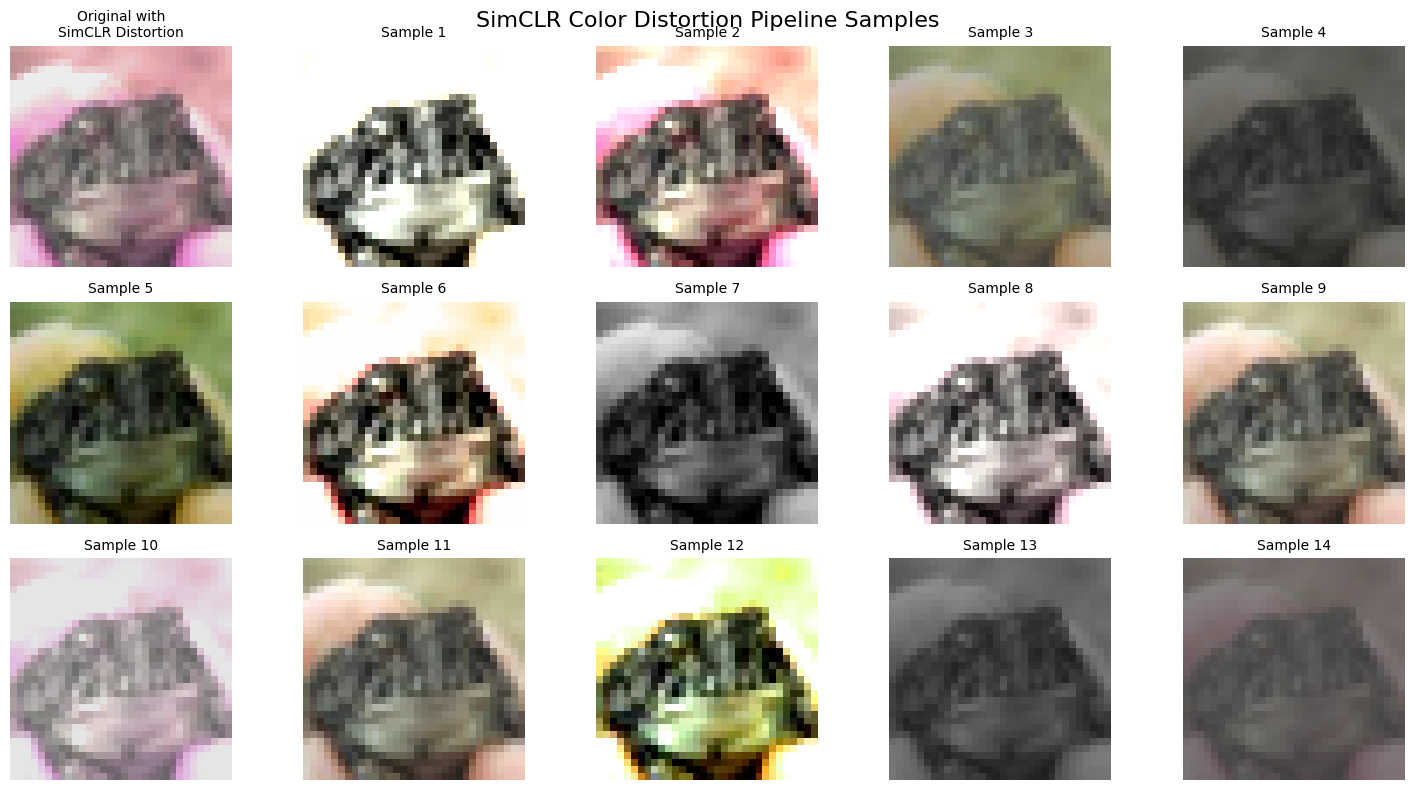

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Load CIFAR-10 dataset
transform = transforms.ToTensor()  # Just convert to tensor, no normalization for visualization
cifar_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Choose some sample images
image_indices = [25, 100, 2021]  # Pick diverse images
images = []
labels = []
for idx in image_indices:
    img, label = cifar_dataset[idx]
    images.append(img)
    labels.append(label)

# Function to convert tensor to displayable image
def tensor_to_img(tensor):
    img = tensor.permute(1, 2, 0).numpy()  # Change from (C,H,W) to (H,W,C)
    # Clip values to [0, 1] range in case of any overflow
    img = np.clip(img, 0, 1)
    return img

# Get the class names
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
class_names = [classes[label] for label in labels]

# Create a figure to display the original and color distorted images
plt.figure(figsize=(15, len(images) * 3))

# Define different color distortion transforms
# 1. Strong color jitter (as used in SimCLR)
strong_jitter = transforms.ColorJitter(
    brightness=0.8,
    contrast=0.8,
    saturation=0.8,
    hue=0.2  # hue is in [0, 0.5] range
)

# 2. Individual component jittering
brightness_jitter = transforms.ColorJitter(brightness=0.8, contrast=0, saturation=0, hue=0)
contrast_jitter = transforms.ColorJitter(brightness=0, contrast=0.8, saturation=0, hue=0)
saturation_jitter = transforms.ColorJitter(brightness=0, contrast=0, saturation=0.8, hue=0)
hue_jitter = transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0.2)

# 3. Grayscale transformation
grayscale = transforms.Grayscale(num_output_channels=3)  # Keep 3 channels for visualization

# For each image, apply the transformations
for img_idx, (img, class_name) in enumerate(zip(images, class_names)):
    row = img_idx * 1
    
    # Define number of columns (original + 5 transforms)
    num_cols = 6
    
    # Original image
    plt.subplot(len(images), num_cols, row * num_cols + 1)
    plt.imshow(tensor_to_img(img))
    plt.title(f'Original: {class_name}')
    plt.axis('off')
    
    # 1. Strong color jitter (SimCLR style)
    jittered = strong_jitter(img)
    plt.subplot(len(images), num_cols, row * num_cols + 2)
    plt.imshow(tensor_to_img(jittered))
    plt.title('Strong Color Jitter')
    plt.axis('off')
    
    # 2. Brightness jitter
    br_jittered = brightness_jitter(img)
    plt.subplot(len(images), num_cols, row * num_cols + 3)
    plt.imshow(tensor_to_img(br_jittered))
    plt.title('Brightness Jitter')
    plt.axis('off')
    
    # 3. Contrast jitter
    cont_jittered = contrast_jitter(img)
    plt.subplot(len(images), num_cols, row * num_cols + 4)
    plt.imshow(tensor_to_img(cont_jittered))
    plt.title('Contrast Jitter')
    plt.axis('off')
    
    # 4. Saturation jitter
    sat_jittered = saturation_jitter(img)
    plt.subplot(len(images), num_cols, row * num_cols + 5)
    plt.imshow(tensor_to_img(sat_jittered))
    plt.title('Saturation Jitter')
    plt.axis('off')
    
    # 5. Grayscale
    gray = grayscale(img)
    plt.subplot(len(images), num_cols, row * num_cols + 6)
    plt.imshow(tensor_to_img(gray))
    plt.title('Grayscale')
    plt.axis('off')

plt.tight_layout()
plt.suptitle('Color Distortion Augmentations for SimCLR', fontsize=16, y=0.98)
plt.savefig('color_distortion_examples.png')
plt.show()

# Show multiple strong color jitter samples for one image
plt.figure(figsize=(15, 10))

# Select one image
selected_img = images[0]
selected_class = class_names[0]

# Show original
plt.subplot(3, 4, 1)
plt.imshow(tensor_to_img(selected_img))
plt.title(f'Original: {selected_class}')
plt.axis('off')

# Generate and show multiple color jittered versions
for i in range(11):
    # Apply strong color jitter
    jittered = strong_jitter(selected_img)
    
    # Show the result
    plt.subplot(3, 4, i + 2)
    plt.imshow(tensor_to_img(jittered))
    plt.title(f'Jitter Sample {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.suptitle('Multiple Strong Color Jitter Samples of the Same Image', fontsize=16, y=0.98)
plt.savefig('multiple_color_jitter_samples.png')
plt.show()

# Show SimCLR-style color distortion in context
plt.figure(figsize=(15, 8))

# Create the SimCLR color distortion pipeline
# In SimCLR, color jitter is applied with probability 0.8, then grayscale with probability 0.2
simclr_color_distortion = transforms.Compose([
    transforms.RandomApply([strong_jitter], p=0.8),
    transforms.RandomGrayscale(p=0.2)
])

# For one image, show many different SimCLR color distortions
rows, cols = 3, 5
for i in range(rows * cols):
    # Apply SimCLR color distortion
    distorted = simclr_color_distortion(selected_img)
    
    # Show the result
    plt.subplot(rows, cols, i + 1)
    plt.imshow(tensor_to_img(distorted))
    if i == 0:
        plt.title(f'Original with\nSimCLR Distortion', fontsize=10)
    else:
        plt.title(f'Sample {i}', fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.suptitle('SimCLR Color Distortion Pipeline Samples', fontsize=16, y=0.98)
plt.savefig('simclr_color_distortion_samples.png')
plt.show()

#### Gaussian Blur

Image type: <class 'PIL.Image.Image'>


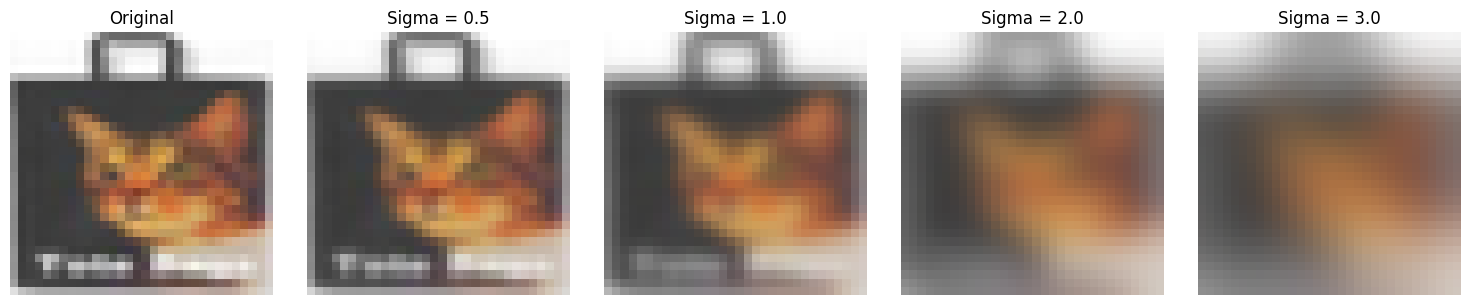

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from PIL import Image, ImageFilter

# Load CIFAR-10 dataset without any transforms
dataset = CIFAR10(root='./data', train=True, transform=None, download=True)

# Load a sample image
image, label = dataset[3000]
print(f"Image type: {type(image)}")

# Handle the image based on its type
if isinstance(image, np.ndarray):
    image_pil = Image.fromarray(image)
elif isinstance(image, Image.Image):
    image_pil = image  # Already a PIL Image
else:
    print(f"Unexpected image type: {type(image)}")
    # Try to convert anyway as a fallback
    try:
        image_pil = Image.fromarray(np.array(image))
    except:
        print("Could not convert image to PIL Image")
        exit(1)

# Create a figure to display different blur levels
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

# Original image
axes[0].imshow(np.array(image_pil))
axes[0].set_title('Original')
axes[0].axis('off')

# Apply different levels of Gaussian blur
sigma_values = [0.5, 1.0, 2.0, 3.0]
for i, sigma in enumerate(sigma_values):
    blurred = image_pil.filter(ImageFilter.GaussianBlur(radius=sigma))
    axes[i+1].imshow(np.array(blurred))
    axes[i+1].set_title(f'Sigma = {sigma}')
    axes[i+1].axis('off')

plt.tight_layout()
plt.show()

Image type: <class 'PIL.Image.Image'>
Image shape/size: (32, 32)
Class label: 3 (cat)


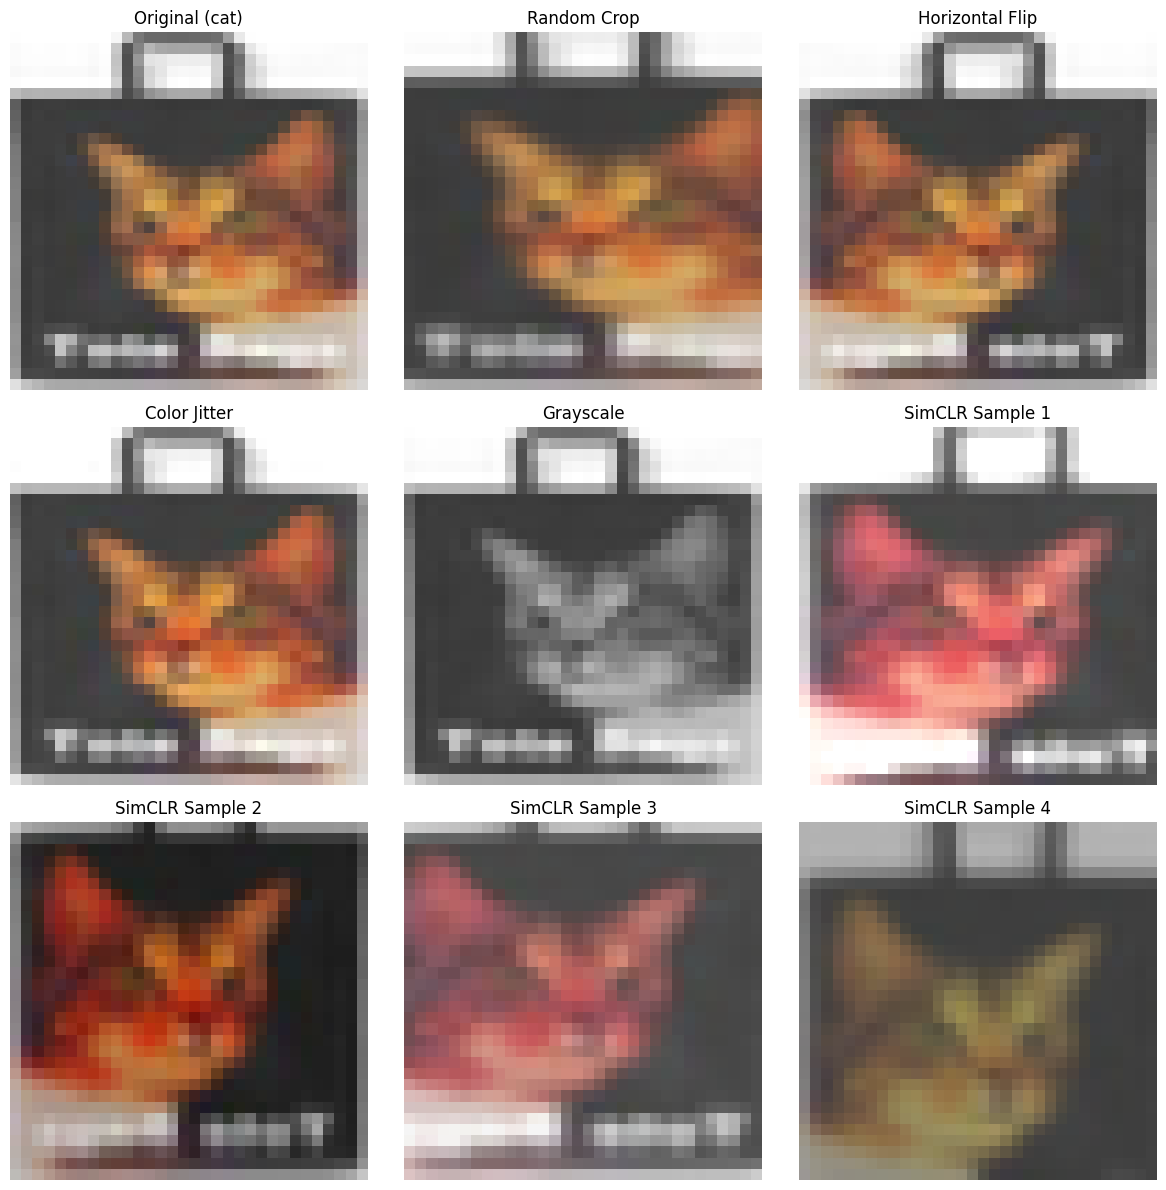

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from PIL import Image

# Load CIFAR-10 dataset without any transforms
dataset = CIFAR10(root='./data', train=True, transform=None, download=True)

# Pick a specific index
image_idx = 3000  # Arbitrary index, adjust if needed

# Get the image and verify its format
image, label = dataset[image_idx]
print(f"Image type: {type(image)}")
print(f"Image shape/size: {image.shape if hasattr(image, 'shape') else image.size}")
print(f"Class label: {label} ({dataset.classes[label]})")

# Convert to PIL Image if needed
if isinstance(image, np.ndarray):
    image_pil = Image.fromarray(image)
elif isinstance(image, Image.Image):
    image_pil = image  # Already a PIL Image
else:
    print(f"Unexpected image type: {type(image)}")
    exit(1)

# Define SimCLR-style augmentations
simclr_augmentations = [
    transforms.RandomResizedCrop(32, scale=(0.5, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([
        transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)  # brightness, contrast, saturation, hue
    ], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor()
]

# Create individual transform for each augmentation
crop_transform = transforms.Compose([simclr_augmentations[0], transforms.ToTensor()])
flip_transform = transforms.Compose([transforms.RandomHorizontalFlip(p=1.0), transforms.ToTensor()])
color_transform = transforms.Compose([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1), transforms.ToTensor()])
gray_transform = transforms.Compose([transforms.RandomGrayscale(p=1.0), transforms.ToTensor()])

# Apply SimCLR full transform (multiple times to show variation)
simclr_transform = transforms.Compose(simclr_augmentations)
simclr_samples = [simclr_transform(image_pil) for _ in range(5)]

# Function to safely convert tensor to numpy for display
def tensor_to_display(tensor):
    if isinstance(tensor, torch.Tensor):
        return tensor.permute(1, 2, 0).numpy()
    return np.array(tensor)

# Create a figure with all augmentations
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

# Original image
axes[0, 0].imshow(np.array(image_pil))
axes[0, 0].set_title(f'Original ({dataset.classes[label]})')
axes[0, 0].axis('off')

# Individual augmentations
axes[0, 1].imshow(tensor_to_display(crop_transform(image_pil)))
axes[0, 1].set_title('Random Crop')
axes[0, 1].axis('off')

axes[0, 2].imshow(tensor_to_display(flip_transform(image_pil)))
axes[0, 2].set_title('Horizontal Flip')
axes[0, 2].axis('off')

axes[1, 0].imshow(tensor_to_display(color_transform(image_pil)))
axes[1, 0].set_title('Color Jitter')
axes[1, 0].axis('off')

axes[1, 1].imshow(tensor_to_display(gray_transform(image_pil)))
axes[1, 1].set_title('Grayscale')
axes[1, 1].axis('off')

# SimCLR combined transforms (4 random samples)
axes[1, 2].imshow(tensor_to_display(simclr_samples[0]))
axes[1, 2].set_title('SimCLR Sample 1')
axes[1, 2].axis('off')

axes[2, 0].imshow(tensor_to_display(simclr_samples[1]))
axes[2, 0].set_title('SimCLR Sample 2')
axes[2, 0].axis('off')

axes[2, 1].imshow(tensor_to_display(simclr_samples[2]))
axes[2, 1].set_title('SimCLR Sample 3')
axes[2, 1].axis('off')

axes[2, 2].imshow(tensor_to_display(simclr_samples[3]))
axes[2, 2].set_title('SimCLR Sample 4')
axes[2, 2].axis('off')

plt.tight_layout()
plt.show()



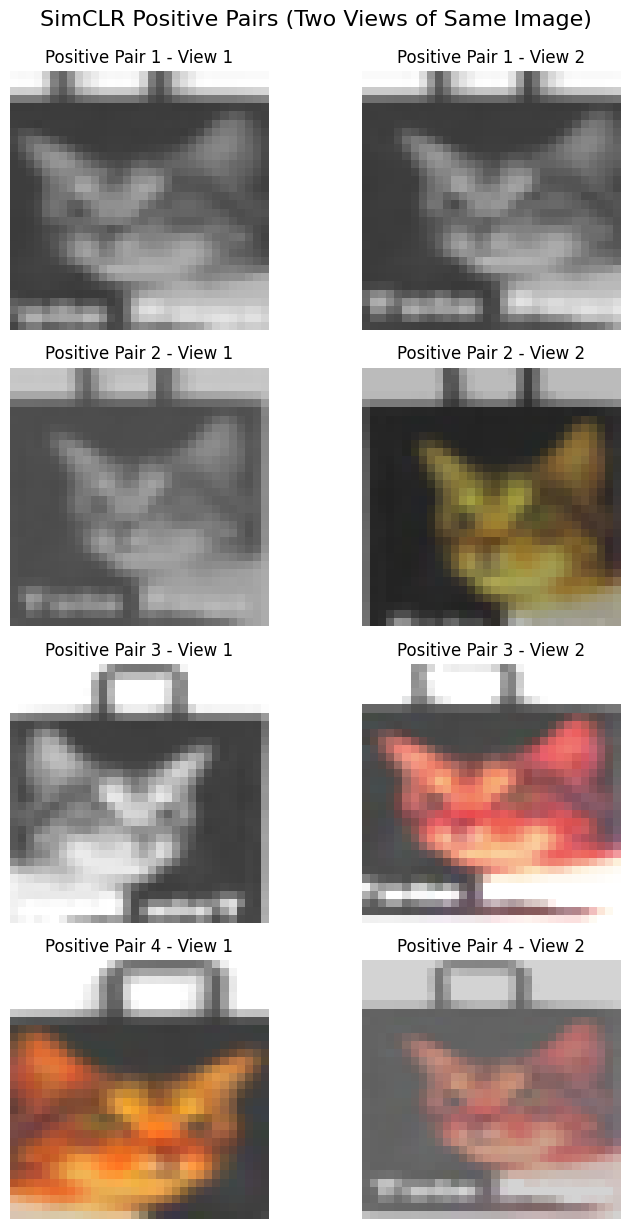

In [5]:
# Show pairs of SimCLR augmentations (how they're used in training)
fig, axes = plt.subplots(4, 2, figsize=(8, 12))

for i in range(4):
    # Generate two augmented views of the same image
    view1 = simclr_transform(image_pil)
    view2 = simclr_transform(image_pil)
    
    axes[i, 0].imshow(tensor_to_display(view1))
    axes[i, 0].set_title(f'Positive Pair {i+1} - View 1')
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(tensor_to_display(view2))
    axes[i, 1].set_title(f'Positive Pair {i+1} - View 2')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.suptitle('SimCLR Positive Pairs (Two Views of Same Image)', y=1.02, fontsize=16)
plt.show()

## Training the SimCLR 

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [4]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# SimCLR parameters
batch_size = 256  
epochs = 100  
temperature = 0.5
learning_rate = 0.001
feature_dim = 128  
weight_decay = 1e-4


Using device: cuda


In [5]:
# Define data augmentation pipeline
class TwoCropTransform:
    """Create two crops of the same image"""
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, x):
        return [self.transform(x), self.transform(x)]

# Define data augmentations as per SimCLR paper
def get_simclr_pipeline_transform(size):
    """Return a set of data augmentation transformations as described in the SimCLR paper."""
    color_jitter = transforms.ColorJitter(0.8, 0.8, 0.8, 0.2)
    
    # Re-added Gaussian blur and grayscale as in the original SimCLR paper
    data_transforms = transforms.Compose([
        transforms.RandomResizedCrop(size=size),
        transforms.RandomHorizontalFlip(),
        transforms.RandomApply([color_jitter], p=0.8),
        transforms.RandomGrayscale(p=0.2),
        transforms.GaussianBlur(kernel_size=int(0.1 * size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return data_transforms

In [6]:
# Define the ResNet backbone with projection head
class SimCLRModel(nn.Module):
    def __init__(self, feature_dim=128):
        super(SimCLRModel, self).__init__()
        
        # Use ResNet18 as the encoder backbone
        resnet = torchvision.models.resnet18(weights=None)
        self.encoder = nn.Sequential(*list(resnet.children())[:-1])  
        
        self.projector = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, feature_dim)
        )
        
    def forward(self, x):
        # Get the encoder output
        h = self.encoder(x)
        h = h.view(h.size(0), -1)  # Flatten the output
        
        # Get the projection output
        z = self.projector(h)
        
        return F.normalize(z, dim=1)  # Normalize embeddings to unit hypersphere


In [7]:
# Define the NT-Xent (Normalized Temperature-scaled Cross Entropy) loss
class NTXentLoss(nn.Module):
    def __init__(self, batch_size, temperature=0.5):
        super(NTXentLoss, self).__init__()
        self.batch_size = batch_size
        self.temperature = temperature
        self.criterion = nn.CrossEntropyLoss(reduction="sum")
        
    def _get_mask(self, batch_size):
        # Create mask for positive pairs - create dynamically based on actual batch size
        mask = torch.zeros((2 * batch_size, 2 * batch_size))
        
        # First half of batch matches with second half
        for i in range(batch_size):
            mask[i, batch_size + i] = 1
            mask[batch_size + i, i] = 1
            
        # Remove diagonal (self-similarity)
        mask = mask.fill_diagonal_(0)
        return mask.to(device)
    
    def forward(self, z_i, z_j):
        # Get actual batch size (might be smaller than self.batch_size for last batch)
        current_batch_size = z_i.size(0)
        
        # Create mask dynamically based on actual batch size
        mask = self._get_mask(current_batch_size)
        
        # Concatenate the representations from the two augmentations
        representations = torch.cat([z_i, z_j], dim=0)
        
        # Compute similarity matrix - more memory efficient approach
        similarity_matrix = torch.mm(representations, representations.t())
        
        # Normalize the similarity matrix
        sim_i_j = torch.diag(similarity_matrix, current_batch_size)
        sim_j_i = torch.diag(similarity_matrix, -current_batch_size)
        
        positives = torch.cat([sim_i_j, sim_j_i], dim=0)
        
        # Remove diagonal (self-similarity)
        mask_samples_from_same_repr = ~torch.eye(2 * current_batch_size, dtype=torch.bool, device=device)
        negatives = similarity_matrix[mask_samples_from_same_repr].view(2 * current_batch_size, -1)
        
        # Scale by temperature
        positives = positives / self.temperature
        negatives = negatives / self.temperature
        
        # Create logits and compute loss
        logits = torch.cat([positives.view(-1, 1), negatives], dim=1)
        labels = torch.zeros(2 * current_batch_size, dtype=torch.long, device=device)
        
        loss = self.criterion(logits, labels)
        loss = loss / (2 * current_batch_size)
        
        return loss

In [8]:
# Load a small dataset (CIFAR-10)
def get_cifar10_dataset(subset_size=500):  # Further reduced to just 100 samples
    transform = get_simclr_pipeline_transform(size=32)
    
    # Load the full dataset
    train_dataset = torchvision.datasets.CIFAR10(
        root='./data', 
        train=True,
        download=True, 
        transform=TwoCropTransform(transform)
    )
    
    # Create a very small subset of the data
    indices = torch.randperm(len(train_dataset))[:subset_size]
    subset_dataset = torch.utils.data.Subset(train_dataset, indices)
    
    print(f"Using a tiny subset of {subset_size} images from CIFAR-10")
    
    train_loader = DataLoader(
        subset_dataset, 
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,  # No multiprocessing
        pin_memory=False,  # Disabled
        drop_last=True
    )
    return train_loader

# Define training function
def train_simclr(model, train_loader, optimizer, criterion, epochs):
    model.train()
    losses = []
    
    # Add debugging info
    print(f"Starting training with {len(train_loader)} batches per epoch")
    print(f"Actual batch size: {next(iter(train_loader))[0][0].shape[0]}")
    
    for epoch in range(epochs):
        running_loss = 0.0
        batch_count = 0
        
        for i, images in enumerate(train_loader):
            try:
                # Get the two augmented views of the same batch
                (x_i, x_j) = images[0]
                
                # Add progress info
                if i == 0 or (i+1) % 5 == 0:
                    print(f"Processing batch {i+1}/{len(train_loader)}")
                
                # Debug info for first batch
                if epoch == 0 and i == 0:
                    print(f"Input shape: {x_i.shape}")
                
                x_i, x_j = x_i.to(device), x_j.to(device)

                # Zero the gradients
                optimizer.zero_grad()
                
                # Forward pass for both augmentations with added memory efficiency
                with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
                    z_i = model(x_i)
                    z_j = model(x_j)
                    
                    # Compute loss
                    loss = criterion(z_i, z_j)
                
                # Backward pass
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
                batch_count += 1
                
                # Free up memory
                torch.cuda.empty_cache() if torch.cuda.is_available() else None
                
            except Exception as e:
                print(f"Error in batch {i}: {e}")
                continue
        
        # Record epoch loss
        epoch_loss = running_loss / batch_count if batch_count > 0 else float('inf')
        losses.append(epoch_loss)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Processed {batch_count} batches")
        
        # Save model checkpoint once at the end
        if epoch == epochs - 1:
            torch.save(model.state_dict(), f"simclr_final.pt")
    
    # Plot loss curve
    try:
        plt.figure(figsize=(10, 5))
        plt.plot(losses)
        plt.title('SimCLR Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.savefig('simclr_loss.png')
        plt.show()
    except Exception as e:
        print(f"Could not plot loss curve: {e}")
    
    return model, losses

Using device: cuda
Using a tiny subset of 10000 images from CIFAR-10
Starting SimCLR training on small dataset...
Starting training with 39 batches per epoch
Actual batch size: 256
Processing batch 1/39
Input shape: torch.Size([256, 3, 32, 32])


C:\Users\Rishita\AppData\Local\Temp\ipykernel_13032\1439990884.py:197: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Processing batch 5/39
Processing batch 10/39
Processing batch 15/39
Processing batch 20/39
Processing batch 25/39
Processing batch 30/39
Processing batch 35/39
Epoch 1/100, Loss: 6.0029, Processed 39 batches
Processing batch 1/39
Processing batch 5/39
Processing batch 10/39
Processing batch 15/39
Processing batch 20/39
Processing batch 25/39
Processing batch 30/39
Processing batch 35/39
Epoch 2/100, Loss: 5.8011, Processed 39 batches
Processing batch 1/39
Processing batch 5/39
Processing batch 10/39
Processing batch 15/39
Processing batch 20/39
Processing batch 25/39
Processing batch 30/39
Processing batch 35/39
Epoch 3/100, Loss: 5.7620, Processed 39 batches
Processing batch 1/39
Processing batch 5/39
Processing batch 10/39
Processing batch 15/39
Processing batch 20/39
Processing batch 25/39
Processing batch 30/39
Processing batch 35/39
Epoch 4/100, Loss: 5.6981, Processed 39 batches
Processing batch 1/39
Processing batch 5/39
Processing batch 10/39
Processing batch 15/39
Processing b

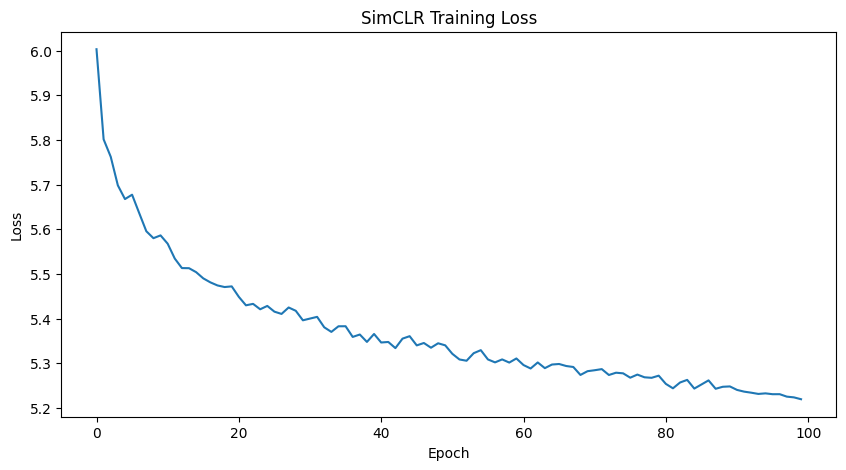

Training complete!


In [1]:
# Main function to run the training
def main():
    # Get the dataset - using only 100 samples
    train_loader = get_cifar10_dataset(subset_size=10000)
    
    # Create the model
    model = SimCLRModel(feature_dim=feature_dim).to(device)
    
    # Create the loss
    criterion = NTXentLoss(batch_size=batch_size, temperature=temperature).to(device)
    
    # Create the optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    # Train the model
    print("Starting SimCLR training on small dataset...")
    model, losses = train_simclr(model, train_loader, optimizer, criterion, epochs)
    
    print("Training complete!")
    # Final model is already saved in the train_simclr function
    
    return model, losses


if __name__ == "__main__":
    main()

## Downstream task

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

In [16]:
# Define the same SimCLR model to load the pre-trained weights
class SimCLRModel(nn.Module):
    def __init__(self, feature_dim=128):
        super(SimCLRModel, self).__init__()
        
        # Use ResNet18 as the encoder backbone
        resnet = torchvision.models.resnet18(weights=None)
        self.encoder = nn.Sequential(*list(resnet.children())[:-1])  # Remove the final FC layer
        
        # Projection head
        self.projector = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, feature_dim)
        )
        
    def forward(self, x):
        # Get the encoder output
        h = self.encoder(x)
        h = h.view(h.size(0), -1)  # Flatten the output
        
        # Get the projection output
        z = self.projector(h)
        
        return F.normalize(z, dim=1)  # Normalize embeddings to unit hypersphere

# Define a linear classifier for CIFAR-10 (or any dataset)
class LinearClassifier(nn.Module):
    def __init__(self, feature_dim=512, num_classes=10):
        super(LinearClassifier, self).__init__()
        self.classifier = nn.Linear(feature_dim, num_classes)
        
    def forward(self, x):
        return self.classifier(x)


# Feature extractor function
def get_features(encoder, dataloader, device):
    """Extract features from the encoder for all images in the dataloader."""
    encoder.eval()
    features = []
    labels = []
    
    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)
            targets = targets.to(device)
            
            # Get representations from the encoder
            h = encoder(images)
            h = h.view(h.size(0), -1)
            
            features.append(h)
            labels.append(targets)
    
    features = torch.cat(features, dim=0)
    labels = torch.cat(labels, dim=0)
    
    return features, labels


# Main function for the downstream task
def train_and_evaluate_classifier(encoder_path, batch_size=128, num_epochs=100):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Load the pre-trained SimCLR model
    simclr_model = SimCLRModel().to(device)
    simclr_model.load_state_dict(torch.load(encoder_path, map_location=device))
    
    # Create encoder model (only the encoder part of SimCLR)
    encoder = simclr_model.encoder
    
    # Freeze the encoder weights
    for param in encoder.parameters():
        param.requires_grad = False
    
    # Load CIFAR-10 dataset (or other dataset used to train SimCLR)
    # Use standard transformation for evaluation (not the SimCLR augmentations)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    train_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=transform)
    test_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=transform)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    
    # Extract features for training and test sets
    print("Extracting features from the encoder...")
    train_features, train_labels = get_features(encoder, train_loader, device)
    test_features, test_labels = get_features(encoder, test_loader, device)
    
    # Create a simple linear classifier
    classifier = LinearClassifier(feature_dim=512, num_classes=10).to(device)
    
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(classifier.parameters(), lr=0.001)
    
    # Train the classifier
    print("Training linear classifier...")
    train_losses = []
    train_accs = []
    
    for epoch in range(num_epochs):
        classifier.train()
        running_loss = 0.0
        predictions = []
        actual = []
        
        # Single pass through the extracted features
        optimizer.zero_grad()
        outputs = classifier(train_features)
        loss = criterion(outputs, train_labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())
        actual.extend(train_labels.cpu().numpy())
        
        # Calculate accuracy
        accuracy = accuracy_score(actual, predictions)
        
        train_losses.append(running_loss)
        train_accs.append(accuracy)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss:.4f}, Accuracy: {accuracy:.4f}")
    
    # Evaluate the model
    print("Evaluating classifier...")
    classifier.eval()
    with torch.no_grad():
        outputs = classifier(test_features)
        _, predicted = torch.max(outputs.data, 1)
        test_predictions = predicted.cpu().numpy()
        test_actual = test_labels.cpu().numpy()
        
        test_accuracy = accuracy_score(test_actual, test_predictions)
        
        print(f"Test Accuracy: {test_accuracy:.4f}")
        print("\nClassification Report:")
        print(classification_report(test_actual, test_predictions, 
                                   target_names=[f"Class {i}" for i in range(10)]))
        
        # Plot confusion matrix
        cm = confusion_matrix(test_actual, test_predictions)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.savefig('confusion_matrix.png')
        plt.show()
        
        # Plot training curves
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(train_losses)
        plt.title('Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        
        plt.subplot(1, 2, 2)
        plt.plot(train_accs)
        plt.title('Training Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        
        plt.tight_layout()
        plt.savefig('training_curves.png')
        plt.show()
    
    return classifier, test_accuracy

In [10]:
# For evaluation with a subset of training data (linear probe with less data)
def evaluate_with_less_data(encoder_path, data_percentages=[1, 10, 25, 50, 100]):
    """Evaluate how well the encoder works with different amounts of labeled data."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Load the pre-trained SimCLR model
    simclr_model = SimCLRModel().to(device)
    simclr_model.load_state_dict(torch.load(encoder_path, map_location=device))
    encoder = simclr_model.encoder
    
    # Freeze encoder
    for param in encoder.parameters():
        param.requires_grad = False
    
    # Dataset
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    train_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=transform)
    test_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=transform)
    
    full_train_loader = DataLoader(train_dataset, batch_size=128, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)
    
    # Get all train features
    all_train_features, all_train_labels = get_features(encoder, full_train_loader, device)
    test_features, test_labels = get_features(encoder, test_loader, device)
    
    # Results
    results = []
    
    for percentage in data_percentages:
        print(f"\nTraining with {percentage}% of labeled data")
        # Select subset of training data
        if percentage < 100:
            num_samples = int(len(all_train_features) * percentage / 100)
            indices = torch.randperm(len(all_train_features))[:num_samples]
            train_features = all_train_features[indices]
            train_labels = all_train_labels[indices]
        else:
            train_features = all_train_features
            train_labels = all_train_labels
        
        # Train classifier
        classifier = LinearClassifier(feature_dim=512, num_classes=10).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(classifier.parameters(), lr=0.001, weight_decay=1e-4)
        
        # Train for 100 epochs (or until convergence)
        best_acc = 0
        for epoch in range(100):
            classifier.train()
            optimizer.zero_grad()
            outputs = classifier(train_features)
            loss = criterion(outputs, train_labels)
            loss.backward()
            optimizer.step()
            
            # Evaluate
            if epoch % 10 == 0 or epoch == 99:
                classifier.eval()
                with torch.no_grad():
                    outputs = classifier(test_features)
                    _, predicted = torch.max(outputs.data, 1)
                    accuracy = accuracy_score(test_labels.cpu().numpy(), predicted.cpu().numpy())
                    print(f"Epoch {epoch+1}, Test Accuracy: {accuracy:.4f}")
                    best_acc = max(best_acc, accuracy)
        
        results.append((percentage, best_acc))
    
    # Plot results
    percentages, accuracies = zip(*results)
    plt.figure(figsize=(10, 6))
    plt.plot(percentages, accuracies, 'o-')
    plt.title('Performance vs Amount of Labeled Data')
    plt.xlabel('Percentage of Labeled Data')
    plt.ylabel('Test Accuracy')
    plt.grid(True)
    plt.savefig('label_efficiency.png')
    plt.show()
    
    return results

In [11]:
# For visualizing the learned embeddings
def visualize_embeddings(encoder_path):
    """Visualize the learned embeddings using t-SNE."""
    try:
        from sklearn.manifold import TSNE
    except ImportError:
        print("Please install scikit-learn to use this function")
        return
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Load the pre-trained SimCLR model
    simclr_model = SimCLRModel().to(device)
    simclr_model.load_state_dict(torch.load(encoder_path, map_location=device))
    encoder = simclr_model.encoder
    
    # Dataset
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    test_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=transform)
    
    # Use a subset for visualization (t-SNE can be slow with many points)
    subset_size = 2000
    indices = torch.randperm(len(test_dataset))[:subset_size]
    subset_dataset = torch.utils.data.Subset(test_dataset, indices)
    
    loader = DataLoader(subset_dataset, batch_size=128, shuffle=False, num_workers=2)
    
    # Extract features
    features, labels = get_features(encoder, loader, device)
    
    # Apply t-SNE
    print("Applying t-SNE dimensionality reduction...")
    tsne = TSNE(n_components=2, random_state=42)
    features_2d = tsne.fit_transform(features.cpu().numpy())
    
    # Plot
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], 
                         c=labels.cpu().numpy(), cmap='tab10', alpha=0.7)
    plt.colorbar(scatter, ticks=range(10), label='Class')
    plt.title('t-SNE visualization of learned embeddings')
    plt.savefig('tsne_embeddings.png')
    plt.show()
    
    return features_2d, labels.cpu().numpy()


===== Running linear evaluation on full dataset =====
Using device: cuda
Extracting features from the encoder...
Training linear classifier...
Epoch 1/100, Loss: 2.3704, Accuracy: 0.1023
Epoch 2/100, Loss: 2.2991, Accuracy: 0.1296
Epoch 3/100, Loss: 2.2323, Accuracy: 0.1691
Epoch 4/100, Loss: 2.1699, Accuracy: 0.2082
Epoch 5/100, Loss: 2.1118, Accuracy: 0.2515
Epoch 6/100, Loss: 2.0577, Accuracy: 0.2928
Epoch 7/100, Loss: 2.0076, Accuracy: 0.3232
Epoch 8/100, Loss: 1.9611, Accuracy: 0.3476
Epoch 9/100, Loss: 1.9182, Accuracy: 0.3675
Epoch 10/100, Loss: 1.8786, Accuracy: 0.3861
Epoch 11/100, Loss: 1.8421, Accuracy: 0.3991
Epoch 12/100, Loss: 1.8087, Accuracy: 0.4079
Epoch 13/100, Loss: 1.7781, Accuracy: 0.4139
Epoch 14/100, Loss: 1.7501, Accuracy: 0.4169
Epoch 15/100, Loss: 1.7246, Accuracy: 0.4199
Epoch 16/100, Loss: 1.7015, Accuracy: 0.4225
Epoch 17/100, Loss: 1.6805, Accuracy: 0.4247
Epoch 18/100, Loss: 1.6615, Accuracy: 0.4263
Epoch 19/100, Loss: 1.6443, Accuracy: 0.4281
Epoch 20/10

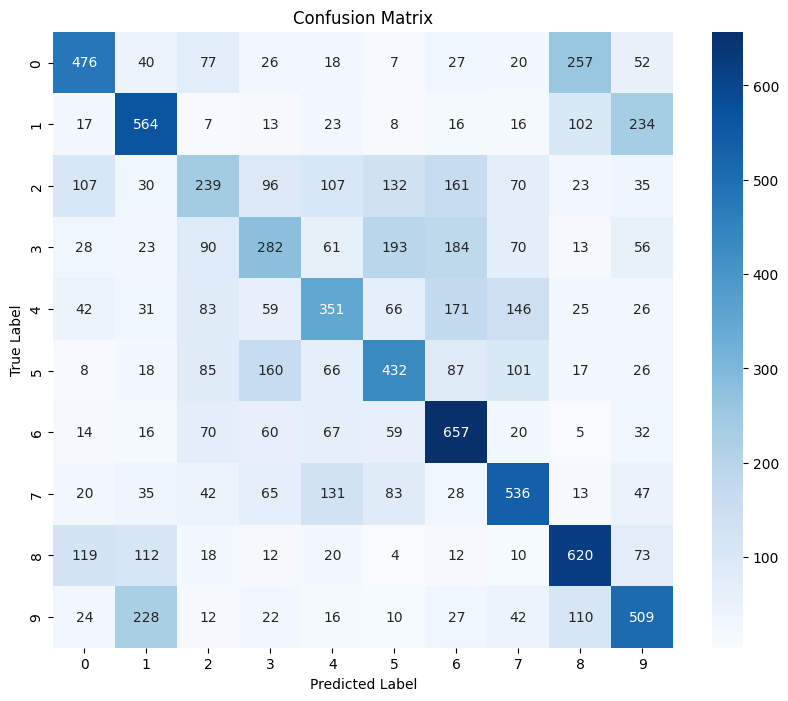

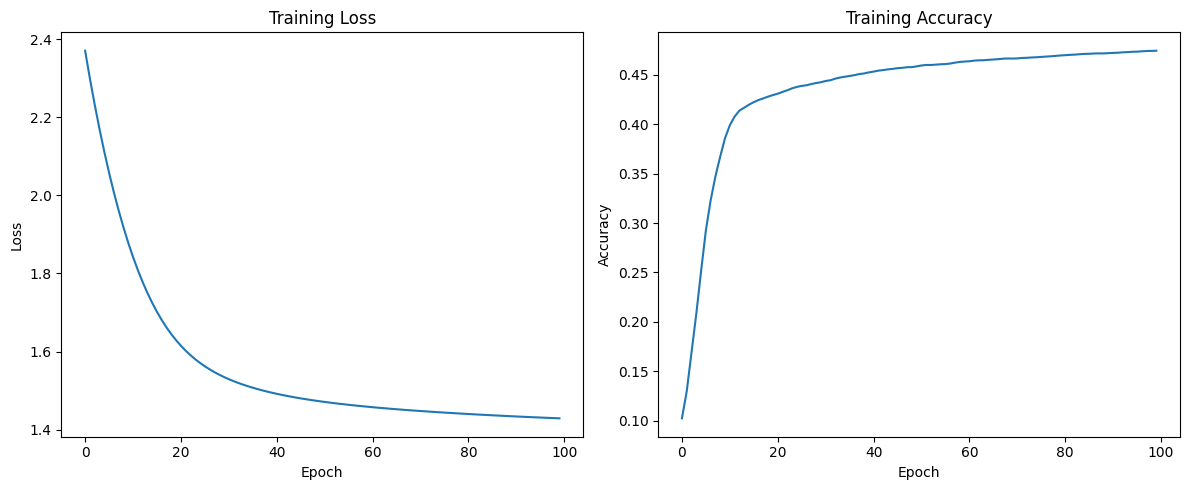

In [17]:
encoder_path = "./final_results/simclr_final.pt"
    
# Basic linear evaluation
print("===== Running linear evaluation on full dataset =====")
classifier, accuracy = train_and_evaluate_classifier(encoder_path)


===== Evaluating label efficiency =====

Training with 1% of labeled data
Epoch 1, Test Accuracy: 0.1330
Epoch 11, Test Accuracy: 0.3898
Epoch 21, Test Accuracy: 0.4111
Epoch 31, Test Accuracy: 0.4148
Epoch 41, Test Accuracy: 0.4192
Epoch 51, Test Accuracy: 0.4212
Epoch 61, Test Accuracy: 0.4246
Epoch 71, Test Accuracy: 0.4269
Epoch 81, Test Accuracy: 0.4288
Epoch 91, Test Accuracy: 0.4296
Epoch 100, Test Accuracy: 0.4282

Training with 10% of labeled data
Epoch 1, Test Accuracy: 0.1612
Epoch 11, Test Accuracy: 0.3894
Epoch 21, Test Accuracy: 0.4296
Epoch 31, Test Accuracy: 0.4435
Epoch 41, Test Accuracy: 0.4469
Epoch 51, Test Accuracy: 0.4502
Epoch 61, Test Accuracy: 0.4529
Epoch 71, Test Accuracy: 0.4564
Epoch 81, Test Accuracy: 0.4598
Epoch 91, Test Accuracy: 0.4607
Epoch 100, Test Accuracy: 0.4631

Training with 25% of labeled data
Epoch 1, Test Accuracy: 0.1553
Epoch 11, Test Accuracy: 0.3902
Epoch 21, Test Accuracy: 0.4253
Epoch 31, Test Accuracy: 0.4383
Epoch 41, Test Accuracy:

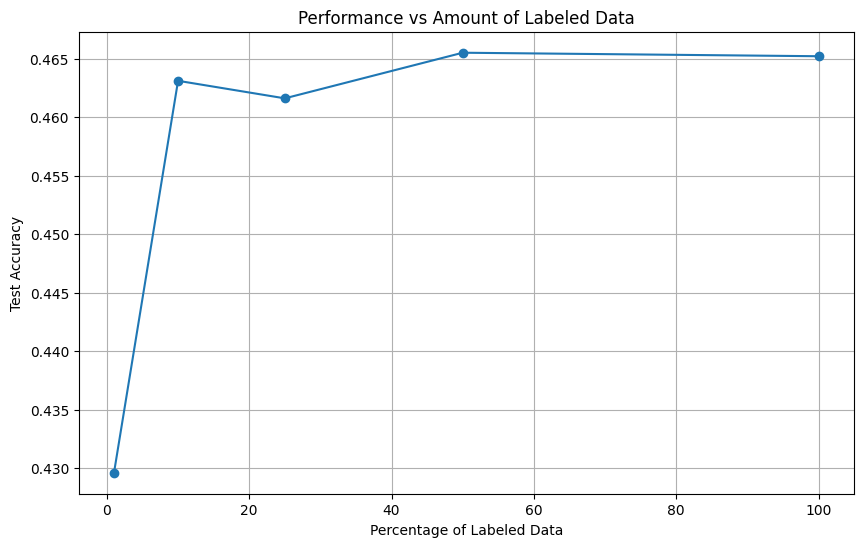

In [18]:
# Evaluation with different amounts of labeled data
print("\n===== Evaluating label efficiency =====")
results = evaluate_with_less_data(encoder_path)


===== Visualizing learned embeddings =====
Applying t-SNE dimensionality reduction...


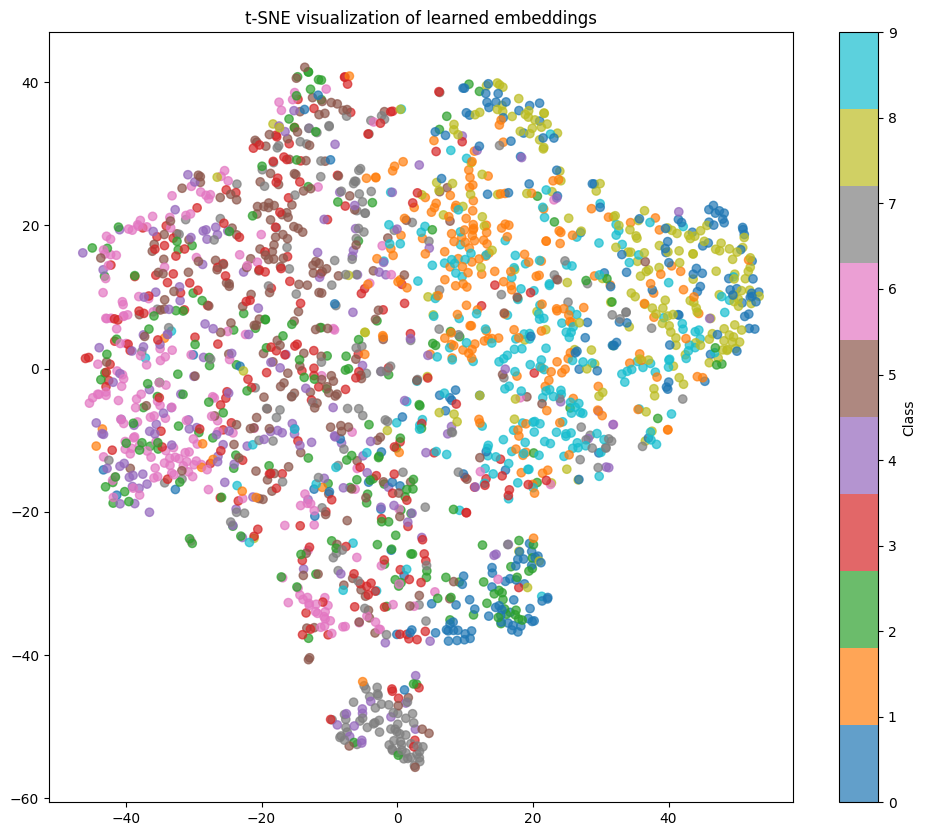

(array([[ -1.2350913, -46.969025 ],
        [ 16.761257 , -27.673573 ],
        [ 15.455952 ,  36.765682 ],
        ...,
        [ 45.03306  ,  -1.2723607],
        [ -4.781325 ,   5.0783134],
        [-35.851254 , -15.266705 ]], dtype=float32),
 array([7, 2, 8, ..., 1, 8, 6]))

In [19]:
# Visualize embeddings 
print("\n===== Visualizing learned embeddings =====")
visualize_embeddings(encoder_path)